In [2]:
import numpy as np
import nilearn
import nibabel as nib
from nilearn import datasets, plotting, regions
import matplotlib.pyplot as plt
import matplotlib as mpl
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
import brainspace
import seaborn as sns
import hcp_utils as hcp
import pandas as pd
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from modeling_utils import *
import os
surf_lh, surf_rh = load_conte69()
from nilearn.connectome import sym_matrix_to_vec
import pickle
import json
import seaborn as sns


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer', 1000)
schaefer_labels_1000 = load_parcellation('schaefer', scale=1000, join=True)

schaefer_region_names = nilearn.datasets.fetch_atlas_schaefer_2018(1000, yeo_networks = 7)
#schaefer_coords = plotting.find_parcellation_cut_coords(schaefer_region_names["maps"])

In [4]:
mpl.rcParams['svg.fonttype'] = 'none'

## Descriptive Stats

In [3]:
#data_paths = json.load(open('data_paths.json', 'r'))

data_paths = {
"COBRE-SCZ": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/COBRE/clean_data/SCZ",
"COBRE-controls": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/COBRE/clean_data/controls",
"LA5c": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data",
"SRPBS-1600-KTT": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/SRPBS_1600/KTT/clean_data",
}

In [3]:
diagnosis_mapping = {
    'CONTROL': 0,
    'SCHZ': 1,
    'Schizophrenia_Strict': 1,
    'No_Known_Disorder': 0,
    4: 1,
    0: 0
}

In [41]:
participants["path"][0]

'/gpfs3/well/margulies/projects/data/COBRE/SCZ/derivatives/fmriprep/clean_data'

In [ ]:
# load json with data_paths
data_paths = json.load(open('data_paths.json', 'r'))

In [ ]:
sys.path.append("../../PyConn")
from NeuroConn.preprocessing.preprocessing import FmriPreppedDataSet

participants = pd.read_csv('participants.csv')
participants["mean_fd"] = np.nan

for data_path in data_paths:
    dataset = FmriPreppedDataSet(data_path)
    for subject in dataset.subjects:
        if subject in participants["participant_id"].values:
            sub_dir = os.path.join(data_path, "derivatives/fmriprep", f"sub-{subject}")
            # search for files ending with "confounds_timeseries.tsv" in all subdirectories
            confounds = []
            for root, dirs, files in os.walk(sub_dir):
                for file in files:
                    if file.endswith("confounds_timeseries.tsv"):
                        confounds.append(os.path.join(root, file))
            # load confounds
            confounds = [pd.read_csv(confound, sep = "\t") for confound in confounds]
            if len(confounds) > 1:
                confounds = pd.concat(confounds, axis = 0)
            else:
                confounds = confounds[0]
            mean_fd = confounds['framewise_displacement'].mean()
            participants.loc[participants["participant_id"] == subject, "mean_fd"] = mean_fd

participants.to_csv('participants.csv', index = False)

In [46]:
grouped =participants.groupby(['dataset'])
grouped.age.describe()

count       mean        std   min   25%   50%    75%   max
dataset                                                                   
COBRE           140.0  37.285714  12.460750  18.0  26.0  35.5  48.25  65.0
LA5c            147.0  32.340136   8.845320  21.0  25.0  30.0  40.00  50.0
SRPBS-1600-KTT  121.0  32.214876  10.204743  19.0  24.0  31.0  39.00  57.0
SRPBS-1600-KUT  202.0  37.707921  13.158764  18.0  24.0  38.0  47.00  78.0
SRPBS-1600-SWA  120.0  30.733333   9.529903  19.0  23.0  27.0  35.25  55.0
SRPBS-1600-UTO  206.0  34.859223  16.529193  16.0  21.0  31.0  44.00  80.0

In [47]:
grouped.mean_fd.describe()

count      mean       std       min       25%       50%  \
dataset                                                                   
COBRE           140.0  0.268914  0.107750  0.077181  0.180296  0.250667   
LA5c            147.0  0.167184  0.085941  0.055963  0.107020  0.148093   
SRPBS-1600-KTT  121.0  0.113433  0.046971  0.046267  0.083525  0.100989   
SRPBS-1600-KUT  202.0  0.147667  0.066520  0.052553  0.099050  0.132522   
SRPBS-1600-SWA  120.0  0.162711  0.078013  0.068363  0.108816  0.139429   
SRPBS-1600-UTO  206.0  0.125349  0.068748  0.050427  0.079736  0.106171   

                     75%       max  
dataset                             
COBRE           0.343920  0.498206  
LA5c            0.205782  0.444074  
SRPBS-1600-KTT  0.134685  0.291186  
SRPBS-1600-KUT  0.179969  0.413938  
SRPBS-1600-SWA  0.186154  0.465692  
SRPBS-1600-UTO  0.149676  0.495019

In [49]:
grouped.sex.value_counts()

dataset         sex
COBRE           0      107
                1       33
LA5c            0       88
                1       59
SRPBS-1600-KTT  0       74
                1       47
SRPBS-1600-KUT  0      113
                1       89
SRPBS-1600-SWA  0      101
                1       19
SRPBS-1600-UTO  1      104
                0      102
Name: count, dtype: int64

In [50]:
grouped.diagnosis.value_counts()

dataset         diagnosis
COBRE           0             81
                1             59
LA5c            0            102
                1             45
SRPBS-1600-KTT  0             75
                1             46
SRPBS-1600-KUT  0            159
                1             43
SRPBS-1600-SWA  0            101
                1             19
SRPBS-1600-UTO  0            170
                1             36
Name: count, dtype: int64

## Gradient

### Atlas

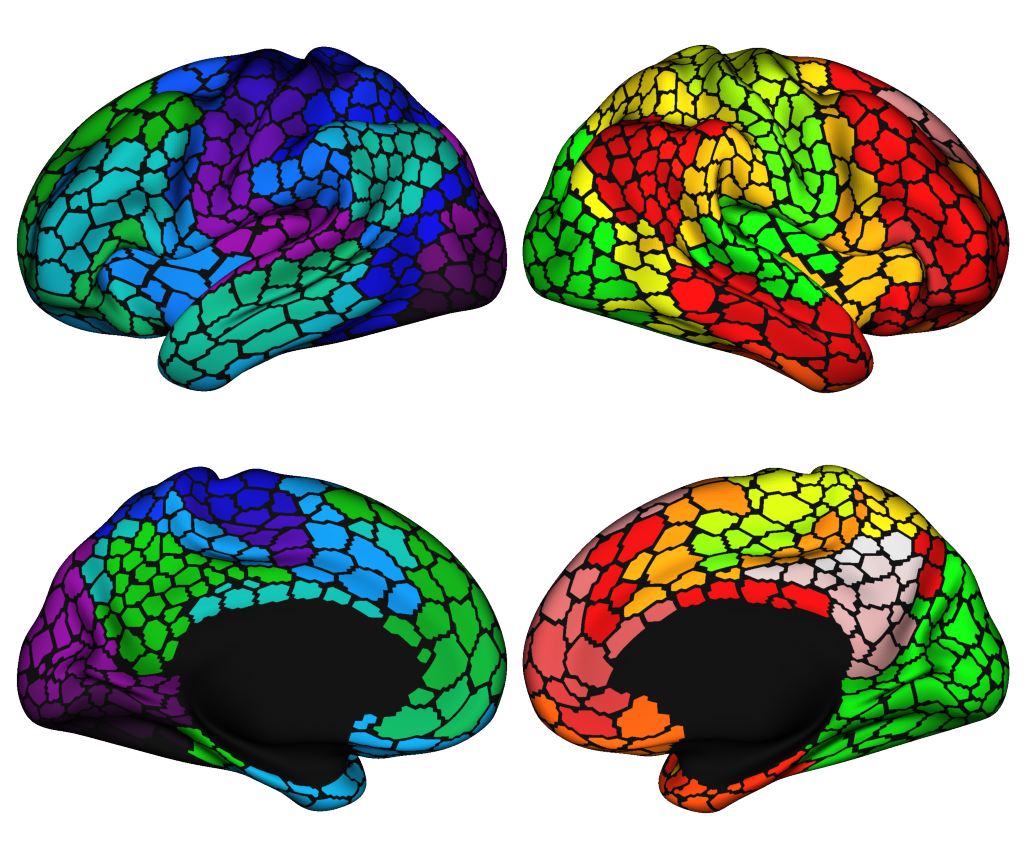

In [177]:

schaefer_plot = Plot(lh, rh, size=(1200, 1000))
schaefer_plot.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=False, cmap="nipy_spectral")
schaefer_plot.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)
fig = schaefer_plot.build()
fig.savefig(f"../../figures/cortex_regions/schaefer1000_atlas.svg", format = "svg", dpi = 300, bbox_inches='tight')

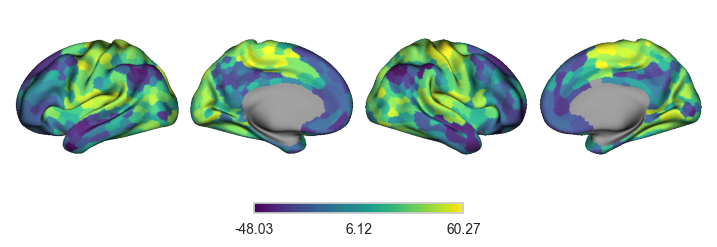

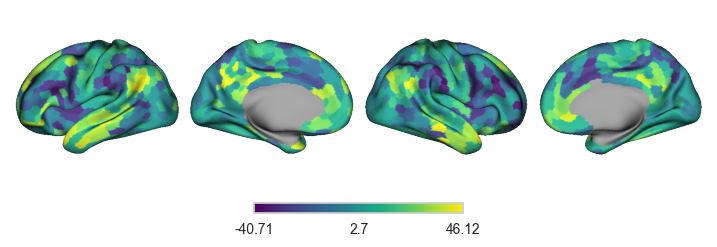

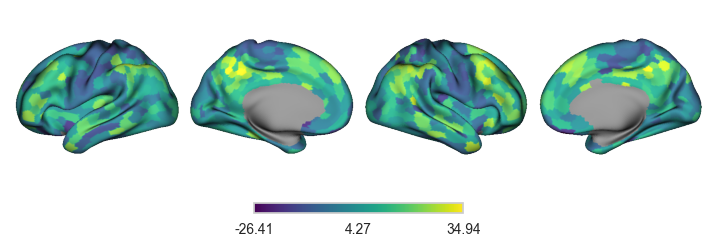

In [50]:
hcp_grad1_plot = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')
hcp_grad1_plot.add_layer({'left': grad_mapped[0][:32492], 'right': grad_mapped[0][32492:]}, cmap = "viridis", zero_transparent=True)
fig = hcp_grad1_plot.build()

hcp_grad2_plot = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')
hcp_grad2_plot.add_layer({'left': grad_mapped[1][:32492], 'right': grad_mapped[1][32492:]}, cmap = "viridis", zero_transparent=True)
fig = hcp_grad2_plot.build()

hcp_grad3_plot = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')
hcp_grad3_plot.add_layer({'left': grad_mapped[2][:32492], 'right': grad_mapped[2][32492:]}, cmap = "viridis", zero_transparent=True)
fig = hcp_grad3_plot.build()


In [509]:
matrix = np.load("/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data/sub-10189/func/z-conn-matrix-sub-10189-rest-schaefer1000.npy")[0]
#corr_plot = plotting.plot_matrix(matrix, figure=(10, 10), vmax=1, vmin=-1, cmap = 'plasma')


In [534]:
from brainspace.gradient.embedding import PCAMaps

pca = PCAMaps(n_components=200)
pca.fit(matrix)
grads_var_explained = pca.lambdas_ / pca.lambdas_.sum()
grads = np.arange(1, 201)
grads_var_explained = np.stack([grads_var_explained, grads])

In [535]:
grads_var_explained = pd.DataFrame(grads_var_explained.T, columns = ["Variance Explained", "Gradients"])

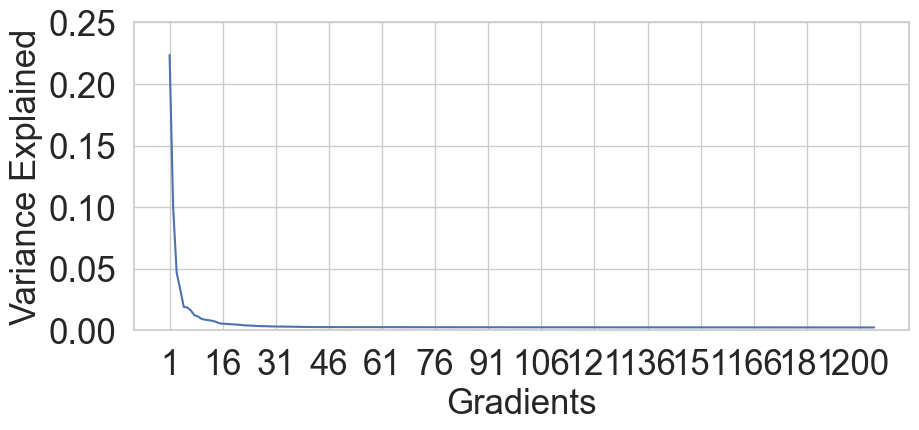

In [537]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=grads_var_explained, x="Gradients", y="Variance Explained")
ax.set_xticks(np.arange(1, 201, 15))
ax.set_xticklabels(np.append(np.arange(1, 201, 15)[:-1], 200))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=25)

ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)

# set the y-axis limits to start at 0 and end at the maximum value of "Variance Explained"
max_var_explained = grads_var_explained["Variance Explained"].max()
ax.set_ylim([-0.0001, 0.25])

plt.savefig("../../figures/grad_var_explained.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [200]:
gradients = np.load("/Users/VictoriaShevchenko/Documents/PhD/SCZ/COBRE/clean_data/controls/sub-A00004087/func/aligned-10gradients-sub-A00004087-rest-schaefer1000.npy")[0]


In [201]:
gradients = gradients[:,:3]

In [202]:
grads3_df = pd.DataFrame(gradients, columns = ["Gradient 1", "Gradient 2", "Gradient 3"])

In [409]:
import plotly.express as px

fig1 = px.scatter(grads3_df, x="Gradient 2", y="Gradient 1",
              color_continuous_scale='Viridis', color='Gradient 1', opacity=1, template='plotly_white', width=600, height=600)
# Create a copy of the initial scatter plot and modify it to only show significant dots with a different color

fig1.update_traces(marker_size=5)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         backgroundcolor="white",
                         gridcolor="black",
                         showbackground=False,
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False,
                         titlefont=dict(size=50)),
                    yaxis=dict(
                        backgroundcolor="white",
                        gridcolor="black",
                        showbackground=False,
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False,
                        titlefont=dict(size=50))))
fig1.update_layout(coloraxis_showscale=False,font=dict(
        size=18))
fig1.write_image("../../figures/grad_embedding.svg")


In [44]:
grads = [None] * 3

for i, g in enumerate(gradients.T[:3]):
    grads[i] = map_to_labels(g, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

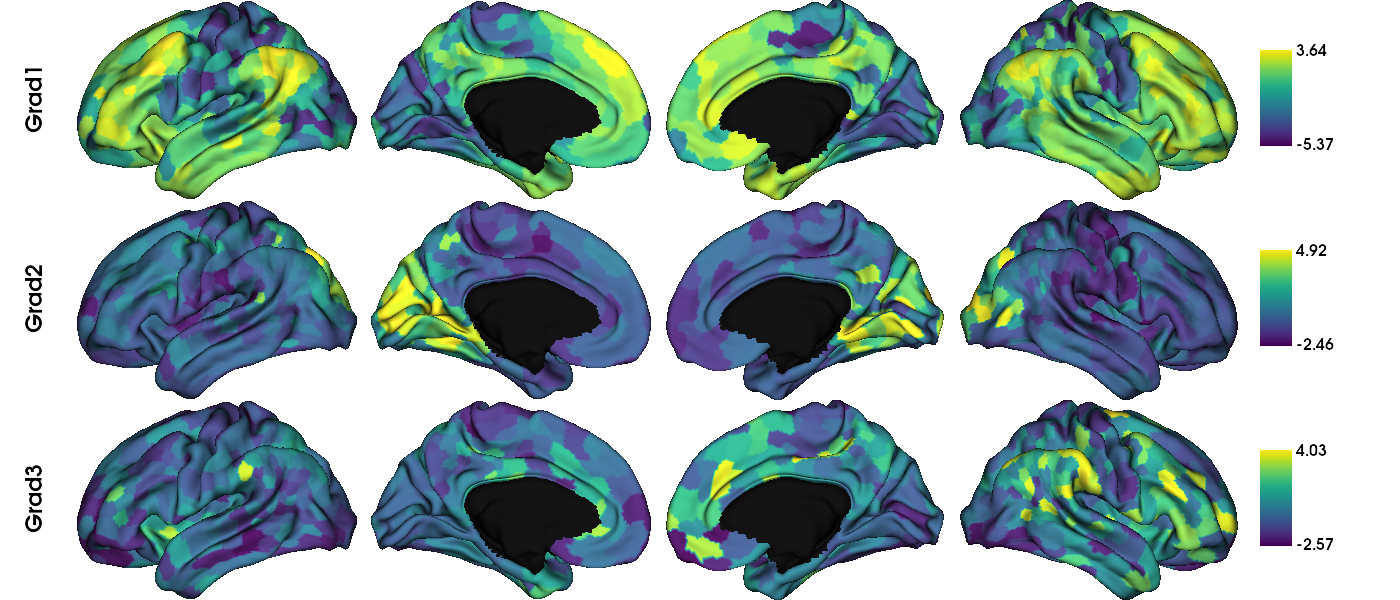

In [51]:
plot_hemispheres(surf_lh, surf_rh, array_name=grads, size=(1400, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.8, embed_nb = True)

In [56]:
dispersion = [np.load(f"/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data/sub-10189/func/{i}") for i in os.listdir("/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data/sub-10189/func/") if "disp" in i]

In [57]:
dispersion = np.array(dispersion)
dispersion.shape

(3, 1000)

In [58]:
disp = [None] * 3
for i, d in enumerate(dispersion):
    disp[i] = map_to_labels(d, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

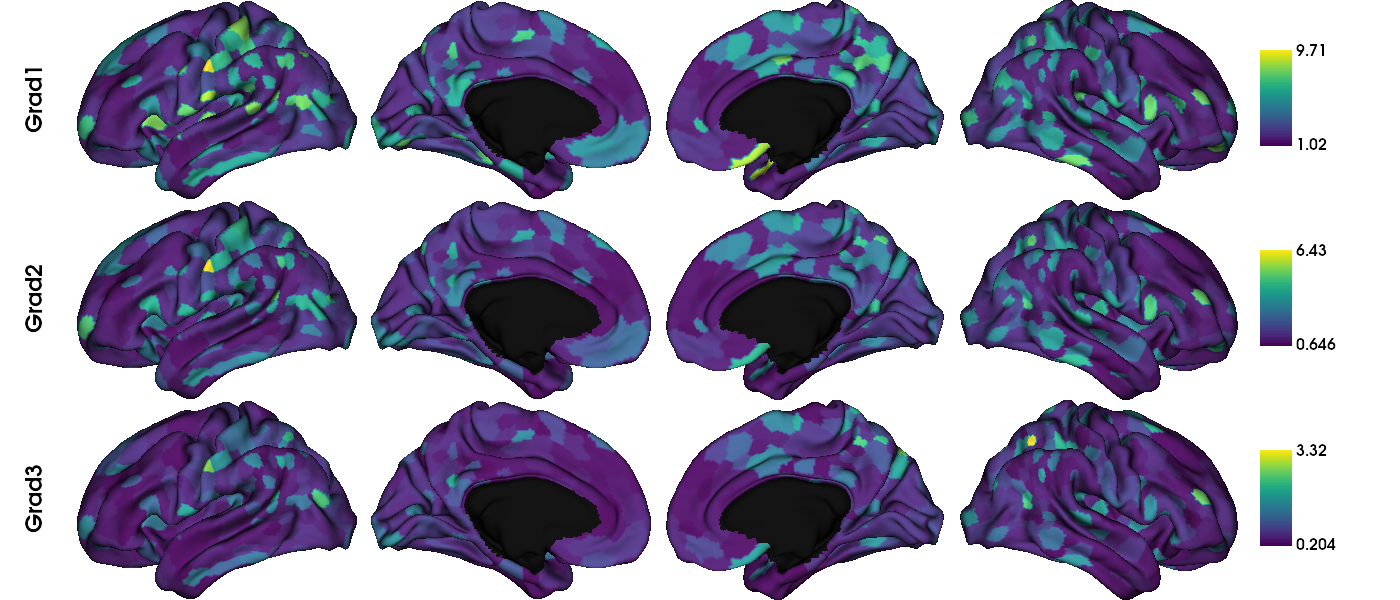

In [59]:
plot_hemispheres(surf_lh, surf_rh, array_name=disp, size=(1400, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.8, embed_nb = True)

# Results

## Feature Importance

In [7]:
feature_importance = np.load("z_feature_importance_matrix.npy")
feature_importance = np.max(feature_importance, axis = 1)
#feature_importance = (feature_importance - np.min(feature_importance)) / (np.max(feature_importance) - np.min(feature_importance))

In [8]:
labels = np.load("feature_labels.npy")
labels = np.array([label.split("_")[0] for label in labels])

In [9]:
feature_importance_df = pd.DataFrame({"Feature Type": labels, "Importance": feature_importance})
feature_importance_df["Feature Type"] = feature_importance_df["Feature Type"].map({"conn":"Connectivity", "grad":"Gradients", "disp":"Dispersion"}) 

In [ ]:
feature_importance_df['Percentile'] = np.percentile(feature_importance_df['Importance'], feature_importance_df['Importance'])

### Load Feature Importance With Percentiles

In [51]:
feature_importance_matrix = np.load("feature_importance_matrix.npy")

In [50]:
feature_importance_grads = pd.read_csv("results/grad_feature_importance.csv")
feature_importance_conn = pd.read_csv("results/conn_feature_importance.csv")
feature_importance_disp = pd.read_csv("results/disp_feature_importance.csv")


In [51]:
feature_importance_grads["Percentile"] = feature_importance_grads["Percentile"].values.astype(int)
feature_importance_conn["Percentile"] = feature_importance_conn["Percentile"].values.astype(int)
feature_importance_disp["Percentile"] = feature_importance_disp["Percentile"].values.astype(int)

In [52]:
feature_importance_df = pd.concat([feature_importance_grads, feature_importance_conn, feature_importance_disp])
feature_importance_df['Decile'] = pd.qcut(feature_importance_df['Percentile'], 10, labels=False) + 1

In [53]:
feature_importance_df

Unnamed: 0 Feature Type  Importance  Percentile  Decile
0            499500    Gradients    0.087449          16       2
1            499501    Gradients    0.067608           5       1
2            499502    Gradients    0.100339          26       3
3            499503    Gradients    0.059756           3       1
4            499504    Gradients    0.142389          60       6
...             ...          ...         ...         ...     ...
1001023     1700523   Dispersion    0.160345          62       7
1001024     1700524   Dispersion    0.131290          35       4
1001025     1700525   Dispersion    0.178040          73       8
1001026     1700526   Dispersion    0.253680          95      10
1001027     1700527   Dispersion    0.106067          15       2

[1700528 rows x 5 columns]

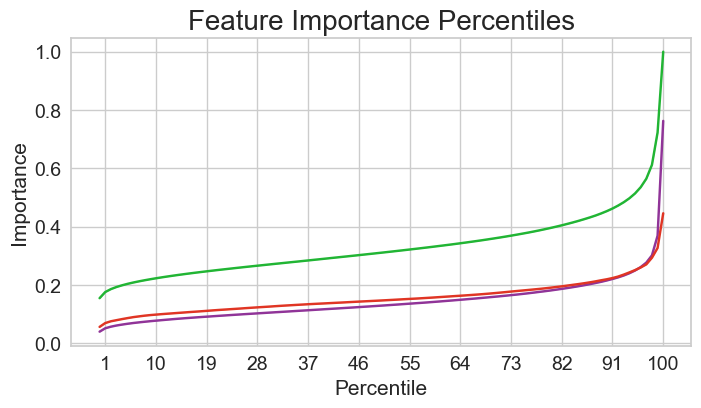

In [54]:
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set_style("whitegrid")

# create the line plot with percentile tick labels
sns.lineplot(data=feature_importance_df, x="Percentile", y = "Importance", hue = "Feature Type", palette=["#903498", '#21b534', '#e03524'], ax=ax, legend = False, errorbar = 'se')
plt.xticks(np.arange(1, 101, 9), np.arange(1, 101, 9))

ax.tick_params(axis='x', labelsize= 14) 
ax.tick_params(axis='y', labelsize= 14) 
plt.title('Feature Importance Percentiles', fontsize = 20)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.savefig("../../figures/feature_importance_percentiles.svg", format = "svg", dpi = 300, bbox_inches='tight')


In [ ]:
feature_importance_matrix[699500:699528].shape

(28, 936)

In [56]:
feature_importance_grads = pd.read_csv("results/grad_feature_importance.csv")
feature_importance_conn = pd.read_csv("results/conn_feature_importance.csv")
feature_importance_disp = pd.read_csv("results/disp_feature_importance.csv")
feature_importance_disp_bthlhm = feature_importance_disp[699500:699528]
feature_importance_disp_bthlhm["Feature Type"] = "Centroid Disp"
feature_importance_disp = feature_importance_disp.drop(feature_importance_disp.index[699500:699528])
feature_importance_disp["Feature Type"] = "Cortex Disp"


#subset 100 most important features for each feature type
# feature_importance_grads = feature_importance_grads.sort_values(by=['Importance'], ascending=False).head(100)
# feature_importance_conn = feature_importance_conn.sort_values(by=['Importance'], ascending=False).head(100)
# feature_importance_disp = feature_importance_disp.sort_values(by=['Importance'], ascending=False).head(100)
# feature_importance_disp_bthlhm = feature_importance_disp_bthlhm.sort_values(by=['Importance'], ascending=False).head(100)


In [57]:
percentile = feature_importance_conn['Importance'].quantile(0.90)
feature_importance_conn = feature_importance_conn[feature_importance_conn['Importance'] >= percentile]

In [58]:
percentile = feature_importance_disp['Importance'].quantile(0.90)
feature_importance_disp = feature_importance_disp[feature_importance_disp['Importance'] >= percentile]

In [59]:
percentile = feature_importance_grads['Importance'].quantile(0.90)
feature_importance_grads = feature_importance_grads[feature_importance_grads['Importance'] >= percentile]

In [60]:
feature_importance_df = pd.concat([feature_importance_grads, feature_importance_conn, feature_importance_disp, feature_importance_disp_bthlhm])

In [61]:
# count the number of observations with importance > 0.2
feature_importance_df[feature_importance_df['Importance'] > 0.2].groupby(['Feature Type']).count()

Unnamed: 0  Importance  Percentile
Feature Type                                     
Centroid Disp           5           5           5
Connectivity        49950       49950       49950
Cortex Disp        100100      100100      100100
Gradients           20000       20000       20000

<Axes: xlabel='Feature Type', ylabel='Importance'>

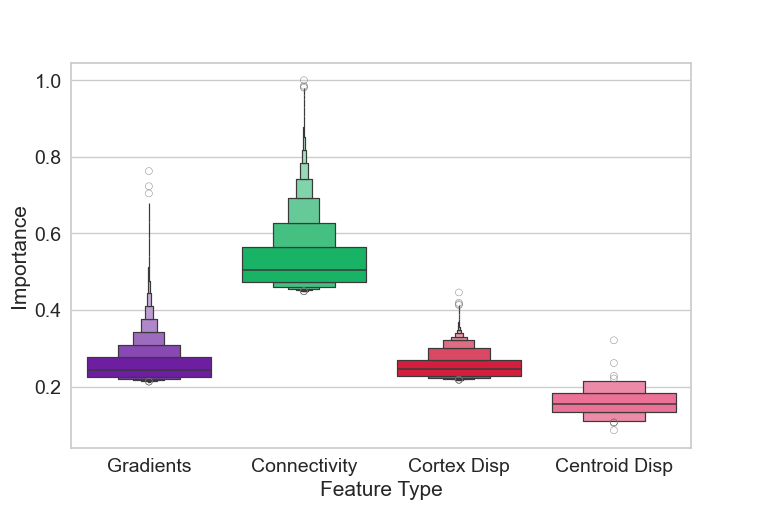

In [122]:
sns.set_style("whitegrid")
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxenplot(data=feature_importance_df, x="Feature Type", y="Importance", hue="Feature Type", palette = ["#7209b7", "#00cc66", "#f2002b", "#ff5d8f"], log_scale = (False, True), k_depth = "trustworthy")

ax.tick_params(axis='x', labelsize= 14)
ax.tick_params(axis='y', labelsize= 14)
#plt.title(label = "99% Threshold for Each Feature Type", fontsize = 20)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.8,1))
plt.savefig("../../figures/feature_importance_top1.svg", format = "svg", dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [115]:
lgd

In [ ]:
plt.savefig("../../figures/feature_importance.png", format = "png", dpi = 300, bbox_extra_artists=(lgd,))

<Figure size 800x550 with 0 Axes>

In [ ]:
plt.savefig("../../figures/feature_importance_top1.svg", format = "svg", dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [24]:
feature_importance_grads = pd.read_csv("results/grad_feature_importance.csv")
feature_labels = np.load("feature_labels.npy").tolist()
grad_labels = np.array([label.split("_")[-1] for label in feature_labels if "grad" in label]).astype(int)


In [25]:
grad_labels = (grad_labels/1000).astype(int) + 1

In [ ]:
len(grad_labels)

200000

In [ ]:
len(feature_importance_grads)

200000

In [26]:
max_gradient_importance = feature_importance_grads["Importance"].values

In [27]:
grad_importance = pd.DataFrame({"Gradient": grad_labels, "Importance": max_gradient_importance})

In [28]:
grad_importance.sort_values(by = "Importance", ascending = False)

Gradient  Importance
70739         71    0.762777
70768         71    0.723147
166088       167    0.704376
63901         64    0.650764
13232         14    0.643596
...          ...         ...
9829          10    0.007786
153820       154    0.006645
80665         81    0.006338
23611         24    0.005803
28020         29    0.000000

[200000 rows x 2 columns]

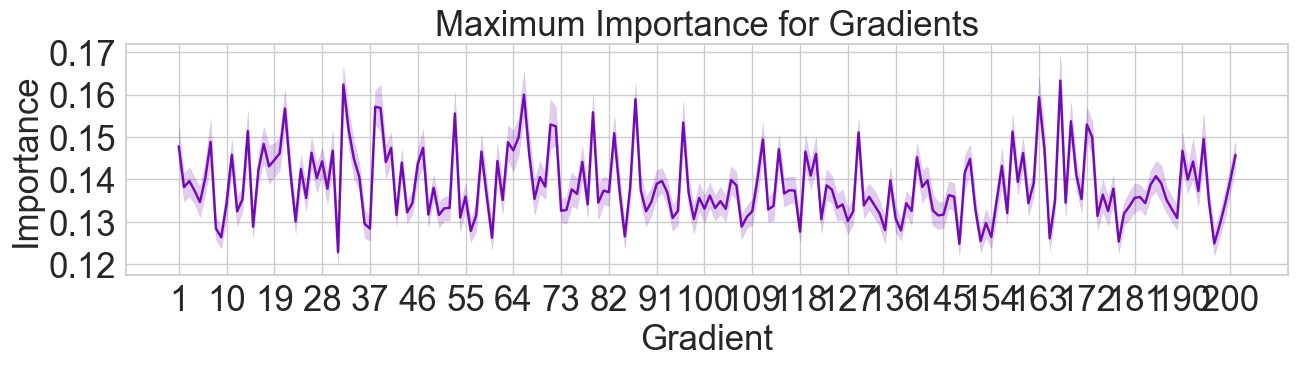

In [29]:
sns.set_style("whitegrid")
fig_dims = (15, 3)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=grad_importance, x="Gradient", y="Importance", color = "#7209b7")
plt.title(label = "Maximum Importance for Gradients", fontsize = 25)
ax.set_xticks(np.arange(1, 201, 9))
ax.set_xticklabels(np.append(np.arange(1, 201, 9)[:-1], 200))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=25)

ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
handles, labels = ax.get_legend_handles_labels()
plt.savefig("../../figures/gradient_importance.svg", format = "svg", dpi = 300, bbox_inches='tight')


In [68]:
perf1Grad_cv = pd.read_csv("results/best_936_1grad_cv.csv")
perfGrad_cv = pd.read_csv("results/best_936_grad_cv.csv")
perfBest_cv = pd.read_csv("results/best_936_cv.csv")
perfBestConn_cv = pd.read_csv("results/best_936_conn_cv.csv")
perfBestDisp_cv = pd.read_csv("results/best_936_disp_cv.csv")
perfBthDisp_cv = pd.read_csv("results/bth_disp_cv.csv")

perf1Grad_test = pd.read_csv("results/best_936_1grad_test.csv")
perfGrad_test = pd.read_csv("results/best_936_grad_test.csv")
perfBest_test = pd.read_csv("results/best_936_test.csv")
perfBestConn_test = pd.read_csv("results/best_936_conn_test.csv")
perfBestDisp_test = pd.read_csv("results/best_936_disp_test.csv")
perfBthDisp_test = pd.read_csv("results/bth_disp_test.csv")

In [210]:
#dummy_acc = perf1Grad.loc[perf1Grad['Model'] == 'Dummy Classifier']['Accuracy'].values[0]
#perf1Grad = perf1Grad[perf1Grad['Accuracy'] > dummy_acc]
#dummy_acc = perfBest1000.loc[perfBest1000['Model'] == 'Dummy Classifier']['Accuracy'].values[0]
#perfBest1000 = perfBest1000[perfBest1000['Accuracy'] > dummy_acc]

In [69]:
perf1Grad_cv["Features"] = "Principal Gradient"
perfGrad_cv["Features"] = "Gradients"
perfBest_cv["Features"] = "Importance-Based (Connectivity)"
perfBestConn_cv["Features"] = "Connectivity"
perfBestDisp_cv["Features"] = "Cortex Dispersion"
perfBthDisp_cv["Features"] = "Centroid Dispersion"


perf1Grad_test["Features"] = "Principal Gradient"
perfGrad_test["Features"] = "Gradients"
perfBest_test["Features"] = "Importance-Based (Connectivity)"
perfBestConn_test["Features"] = "Connectivity"
perfBestDisp_test["Features"] = "Cortex Dispersion"
perfBthDisp_test["Features"] = "Centroid Dispersion"

perf_best936_cv = pd.concat([perf1Grad_cv, perfBest_cv, perfBestDisp_cv, perfGrad_cv,perfBthDisp_cv])
perf_best936_test = pd.concat([perf1Grad_test, perfBest_test, perfBestDisp_test, perfGrad_test, perfBthDisp_test])
# remove rows where accc is lower than dummy classifier
#perf_best936_cv = perf_best936_cv.groupby('Features').apply(lambda x: x.loc[x['Accuracy'] > 0.7344])
perf_best936_cv = perf_best936_cv[perf_best936_cv["Model"] != "Dummy Classifier"]

In [87]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu


statistic, p_value = kruskal(perf1Grad_cv["Accuracy"], perfGrad_cv["Accuracy"], perfBest_cv["Accuracy"], perfBestConn_cv["Accuracy"], perfBestDisp_cv["Accuracy"], perfBthDisp_cv["Accuracy"])
print(statistic, p_value)


16.71230627496025 0.005079005344934632


In [88]:
statistic, p_value = kruskal(perf1Grad_cv["F1"], perfGrad_cv["F1"], perfBest_cv["F1"], perfBestConn_cv["F1"], perfBestDisp_cv["F1"], perfBthDisp_cv["F1"])
print(statistic, p_value)

24.88266573395382 0.00014679310950407398


In [106]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

statistic, p_value = mannwhitneyu(perfBest_cv["Accuracy"], perf1Grad_cv["Accuracy"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBest_cv["Accuracy"], perfGrad_cv["Accuracy"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBest_cv["Accuracy"], perfBestDisp_cv["Accuracy"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBest_cv["Accuracy"], perfBthDisp_cv["Accuracy"])
print(statistic, p_value)


151.0 0.015782562996840048
148.0 0.02271740084591218
154.5 0.010059579851872566
151.0 0.01581122792590644


<Axes: xlabel='Features', ylabel='Accuracy'>

<Axes: xlabel='Features', ylabel='Accuracy'>

[(0.49, 0.82)]

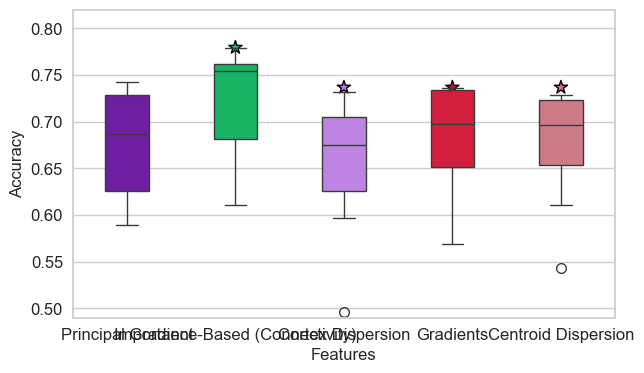

In [109]:
sns.set_style("whitegrid")
kwargs  =   {'edgecolor':"b", # for edge color
             'linewidth':1, # line width of spot
            }
fig_dims = (7, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=perf_best936_test, x="Features", y="Accuracy", hue = "Features", palette = ["#7209b7", "#00cc66","#c174f2", "#f2002b", "#d96e7d"], legend = False, ax = ax, s = 100,edgecolor = "black", linewidth = 1, marker = "*")
sns.boxplot(data=perf_best936_cv, x="Features", y="Accuracy", hue = "Features", dodge = False, palette = ["#7209b7", "#00cc66","#c174f2", "#f2002b", "#d96e7d"], width=0.4)
ax.tick_params(axis='x', labelsize= 12)  
ax.tick_params(axis='y', labelsize= 12) 
ax.set(ylim=(0.49, 0.82))

ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.2,1), fontsize = 15)
#ax.get_legend().remove()
plt.savefig("../../figures/comparsion_perf_features_acc.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [108]:
statistic, p_value = mannwhitneyu(perfBest_cv["F1"], perf1Grad_cv["F1"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBest_cv["F1"], perfGrad_cv["F1"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBest_cv["F1"], perfBestDisp_cv["F1"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBest_cv["F1"], perfBthDisp_cv["F1"])
print(statistic, p_value)


148.5 0.021417978167736294
146.0 0.028983536984445064
169.5 0.0011034390180153315
173.5 0.0005677984236503868


<Axes: xlabel='Features', ylabel='F1'>

<Axes: xlabel='Features', ylabel='F1'>

[(-0.05, 0.6)]

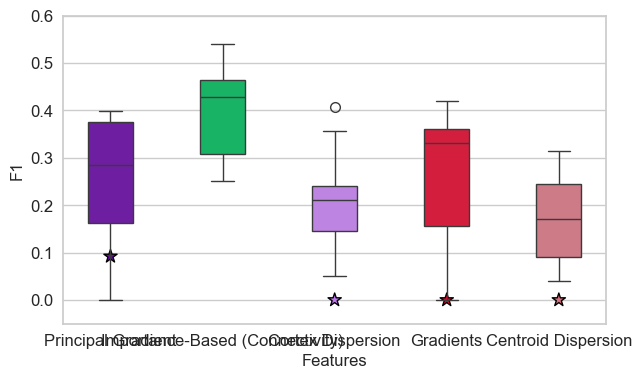

In [110]:
sns.set_style("whitegrid")
fig_dims = (7, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=perf_best936_cv, x="Features", y="F1", hue = "Features", dodge = False, palette = ["#7209b7", "#00cc66","#c174f2", "#f2002b", "#d96e7d"], width=0.4)
sns.scatterplot(data=perf_best936_test, x="Features", y="F1", hue = "Features", palette = ["#7209b7", "#00cc66","#c174f2", "#f2002b", "#d96e7d"], legend = False, ax = ax, s = 100,edgecolor = "black", linewidth = 1, marker = "*")
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
ax.set(ylim=(-0.05, 0.6))
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.2,1), fontsize = 15)
#ax.get_legend().remove()
plt.savefig("../../figures/comparsion_perf_features_f1.svg", format = "svg", dpi = 300, bbox_inches='tight')

#### Mann-Whitney U Test for Grad1 vs 1000 Best Features: AUC

In [ ]:
perf_grad_vs_1000best = perf_grad_vs_1000best[perf_grad_vs_1000best["F1"] > 0]

In [ ]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

f1_1grad = perf_grad_vs_1000best[perf_grad_vs_1000best["Features"] == "Principal Gradient"]["F1"]
f1_1000best = perf_grad_vs_1000best[perf_grad_vs_1000best["Features"] == "Best 1000 Features"]["F1"]
f1_1000bestConn = perf_grad_vs_1000best[perf_grad_vs_1000best["Features"] == "Best 1000 FC Features"]["F1"]
statistic, p_value = kruskal(f1_1grad, f1_1000best, f1_1000bestConn)
print(statistic, p_value)

14.747942410863756 0.0006273718032547797


In [ ]:
statistic, p_value = mannwhitneyu(f1_1grad, f1_1000best)
print(statistic, p_value)
statistic, p_value = mannwhitneyu(f1_1grad, f1_1000bestConn)
print(statistic, p_value)
statistic, p_value = mannwhitneyu(f1_1000best, f1_1000bestConn)
print(statistic, p_value)

22.0 0.0014753589570141526
18.5 0.0007806989290875257
95.0 0.6080768794659228


## Model Performance

In [36]:
best_models_test = pd.read_csv(f"results/best_models_test.csv")
cv_results = pd.read_csv(f"results/model_results_cv.csv")

best_cv_results = cv_results.groupby('N features').apply(lambda x: x.loc[x['Accuracy'].idxmax()])
best_cv_results=best_cv_results.reset_index(drop=True)

dummy_acc = cv_results.loc[cv_results['Model'] == 'Dummy Classifier'].set_index('N features')['Accuracy']
dummy_auc = cv_results.loc[cv_results['Model'] == 'Dummy Classifier'].set_index('N features')['AUC']
dummy_filtered_results = cv_results.groupby('N features').apply(lambda x: x.loc[x['Accuracy'] > dummy_acc[x.name]])
dummy_filtered_results = dummy_filtered_results.reset_index(drop=True)


In [37]:
from scipy.stats import percentileofscore

for n_features in best_models_test["N features"].unique():
    n_features = int(n_features)
    try:
        null_dist_acc = np.load(f"results/null_dist/null_dist_{n_features}.npy")[:, 0]
        null_dist_auc = np.load(f"results/null_dist/null_dist_{n_features}.npy")[:, 1]

        best_acc = best_models_test[best_models_test["N features"] == float(n_features)]["Accuracy"].values[0]
        best_auc = best_models_test[best_models_test["N features"] == float(n_features)]["AUC"].values[0]

        pval_acc = 1-percentileofscore(null_dist_acc, best_acc) / 100
        pval_auc = 1-percentileofscore(null_dist_auc, best_auc) / 100

        best_models_test.loc[best_models_test["N features"] == float(n_features), "Pval Acc"] =  pval_acc
        best_models_test.loc[best_models_test["N features"] == float(n_features), "Pval AUC"] =  pval_auc
    except:
        pass

In [38]:
best_model_test_pca = pd.read_csv(f"results/pca_features_best_model_test.csv")
best_model_test_confound = pd.read_csv(f"results/confounds_best_model_test.csv")
dummy_results = pd.read_csv(f"results/pca_dummy_test.csv")

n_models = 14
n_levels = len(best_models_test["N features"].unique())
best_model_test_confound = pd.concat([best_model_test_confound]*n_levels, ignore_index=True)
best_model_test_confound["N features"] = list(best_models_test["N features"].unique())

best_model_test_pca = pd.concat([best_model_test_pca]*n_levels, ignore_index=True)
best_model_test_pca["N features"] = list(best_models_test["N features"].unique())

dummy_results = pd.concat([dummy_results]*n_levels, ignore_index=True)
dummy_results["N features"] = list(best_models_test["N features"].unique())


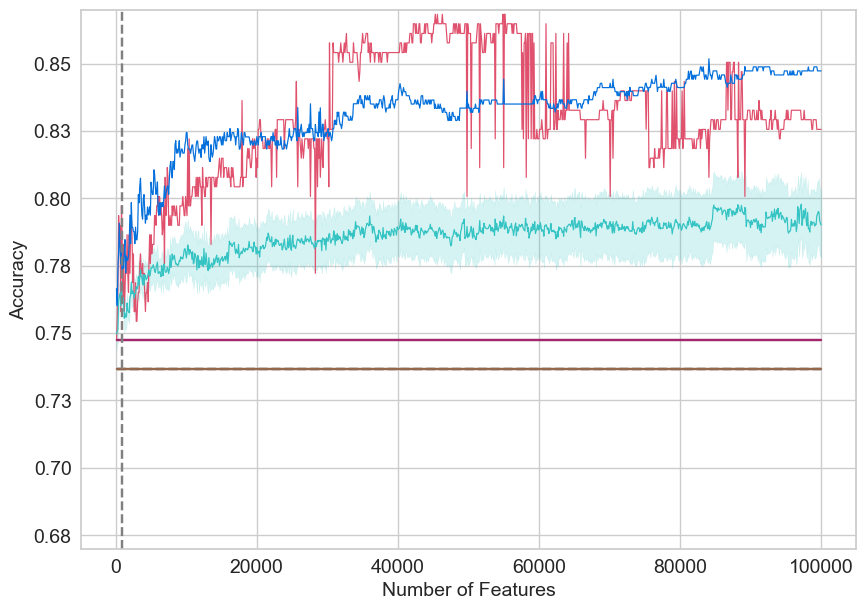

In [63]:
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=best_models_test, estimator = None,
    x="N features", y="Accuracy", color="#e0516d", size = 0.7, legend = False
)
sns.lineplot(
    data=best_cv_results, estimator = None,
    x="N features", y="Accuracy", color="#0470dc", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_filtered_results, errorbar = 'se',
    x="N features", y="Accuracy", color="#35c4c3", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", linestyle = "--"
)
sns.lineplot(
    data=best_model_test_confound,x = "N features", y="Accuracy", color="#95684b"
)
sns.lineplot(
    data=best_model_test_pca,x = "N features", y="Accuracy", color="#a1286a"
)

n_features = best_models_test["N features"].values
pval_acc = best_models_test["Pval Acc"].values

ax.set(ylim=(0.67, 0.87))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# for i in range(1, len(n_features), 10):
#     if pval_acc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.9), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. acc., best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

plt.axvline(x=936, color='gray', linestyle='--')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("../../figures/Accuracy.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [48]:
best_models_test[best_models_test["Accuracy"] <= 0.78]

Model  Accuracy     AUC  Recall   Prec.  \
0                SVM - Linear Kernel    0.7580  0.6881  0.5405  0.5405   
1                SVM - Linear Kernel    0.7722  0.7325  0.6486  0.5581   
3                SVM - Linear Kernel    0.7580  0.7099  0.6081  0.5357   
5       Linear Discriminant Analysis    0.7580  0.7658  0.5270  0.5417   
6       Linear Discriminant Analysis    0.7687  0.7724  0.5541  0.5616   
7                Logistic Regression    0.7544  0.7876  0.5676  0.5316   
8                Logistic Regression    0.7616  0.7866  0.5676  0.5455   
9       Linear Discriminant Analysis    0.7544  0.7768  0.5270  0.5342   
10               Logistic Regression    0.7651  0.7955  0.5811  0.5513   
11               Logistic Regression    0.7651  0.7914  0.5811  0.5513   
13               Logistic Regression    0.7758  0.8027  0.5946  0.5714   
14               Logistic Regression    0.7722  0.7953  0.5946  0.5641   
15               Logistic Regression    0.7794  0.8020  0.5946  0.5789   
16               Logistic Regression    0.7722  0.7951  0.5811  0.5658   
17               Logistic Regression    0.7722  0.7964  0.5946  0.5641   
18               Logistic Regression    0.7758  0.7921  0.5946  0.5714   
19               Logistic Regression    0.7687  0.7932  0.5946  0.5570   
23      Gradient Boosting Classifier    0.7580  0.8014  0.3108  0.5750   
25      Linear Discriminant Analysis    0.7651  0.7881  0.5135  0.5588   
26               Logistic Regression    0.7758  0.7983  0.5676  0.5753   
27      Linear Discriminant Analysis    0.7580  0.7807  0.5135  0.5429   
29               Logistic Regression    0.7758  0.7970  0.5811  0.5733   
41      Linear Discriminant Analysis    0.7794  0.8078  0.5676  0.5833   
44               SVM - Linear Kernel    0.7758  0.7176  0.5946  0.5714   
118  Light Gradient Boosting Machine    0.7473  0.7408  0.2838  0.5385   
123  Light Gradient Boosting Machine    0.7544  0.7512  0.3243  0.5581   
147  Light Gradient Boosting Machine    0.7616  0.8050  0.2568  0.6129   
149  Light Gradient Boosting Machine    0.7758  0.7880  0.3243  0.6486   
150  Light Gradient Boosting Machine    0.7651  0.8019  0.3243  0.6000   
151  Light Gradient Boosting Machine    0.7722  0.7731  0.3243  0.6316   
153  Light Gradient Boosting Machine    0.7722  0.7843  0.2973  0.6471   
154  Light Gradient Boosting Machine    0.7794  0.8074  0.3108  0.6765   
157  Light Gradient Boosting Machine    0.7651  0.7844  0.2838  0.6176   
162  Light Gradient Boosting Machine    0.7687  0.8043  0.2838  0.6364   
163  Light Gradient Boosting Machine    0.7651  0.8110  0.2703  0.6250   
252     Linear Discriminant Analysis    0.7651  0.7881  0.5270  0.5571   
253     Linear Discriminant Analysis    0.7687  0.7949  0.5405  0.5634   
254     Linear Discriminant Analysis    0.7616  0.7944  0.5135  0.5507   
268              SVM - Linear Kernel    0.7722  0.7629  0.7432  0.5500   
296  Light Gradient Boosting Machine    0.7651  0.7850  0.3243  0.6000   

         F1   Kappa     MCC  N features  Pval Acc      Pval AUC  
0    0.5405  0.3763  0.3763         700  0.112821  1.110223e-16  
1    0.6000  0.4420  0.4445        2000  0.034602  1.110223e-16  
3    0.5696  0.4022  0.4038        2600  0.195000  0.000000e+00  
5    0.5342  0.3708  0.3709        2700  0.198000  0.000000e+00  
6    0.5578  0.4012  0.4012        2800  0.005000  0.000000e+00  
7    0.5490  0.3806  0.3809        3000  0.290500  0.000000e+00  
8    0.5563  0.3934  0.3935        3100  0.150000  0.000000e+00  
9    0.5306  0.3644  0.3644        2900  0.292000  0.000000e+00  
10   0.5658  0.4050  0.4052        3300  0.292500  0.000000e+00  
11   0.5658  0.4050  0.4052        3200  0.088000  0.000000e+00  
13   0.5828  0.4296  0.4297        3400  0.022727  0.000000e+00  
14   0.5789  0.4230  0.4233        3700  0.031000  0.000000e+00  
15   0.5867  0.4362  0.4363        3500  0.003000  0.000000e+00  
16   0.5733  0.4180  0.4181        4000  0.024000  0.000000e+00  
17   0

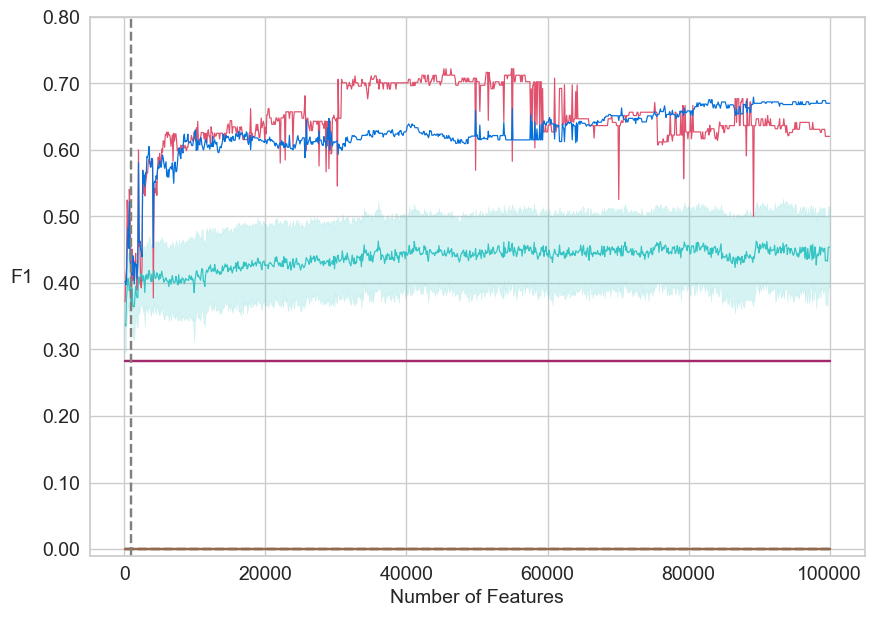

In [41]:
sns.set_style("whitegrid")
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=best_models_test, estimator = None,
    x="N features", y="F1", color="#e0516d", size = 0.7, legend = False
)

sns.lineplot(
    data=best_cv_results, estimator = None,
    x="N features", y="F1", color="#0470dc", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_filtered_results, errorbar = 'se',
    x="N features", y="F1", color="#35c4c3", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="F1", color="#464846", linestyle = "--"
)
sns.lineplot(
    data=best_model_test_confound,x = "N features", y="F1", color="#95684b"
)
sns.lineplot(
    data=best_model_test_pca,x = "N features", y="F1", color="#a1286a"
)
#ax.set(ylim=(0.67, 0.86))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

pval_auc = best_models_test["Pval AUC"].values
ax.set(ylim=(-0.01, 0.8))
# for i in range(1, len(n_features), 10):
#     if pval_auc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.84), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. F1, best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

plt.axvline(x=936, color='gray', linestyle='--')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("F1", fontsize=14, rotation = 0, labelpad = 15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

plt.savefig("../../figures/F1.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [ ]:
sns.lineplot(
    data=best_models_test, estimator = None,
    x="N features", y="Accuracy", color="#e0516d", size = 0.7, legend = False
)
sns.lineplot(
    data=best_cv_results, estimator = None,
    x="N features", y="Accuracy", color="#0470dc", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_filtered_results, errorbar = 'se',
    x="N features", y="Accuracy", color="#35c4c3", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", linestyle = "--"
)
sns.lineplot(
    data=best_model_test_confound,x = "N features", y="Accuracy", color="#95684b"
)
sns.lineplot(
    data=best_model_test_pca,x = "N features", y="Accuracy", color="#a1286a"
)

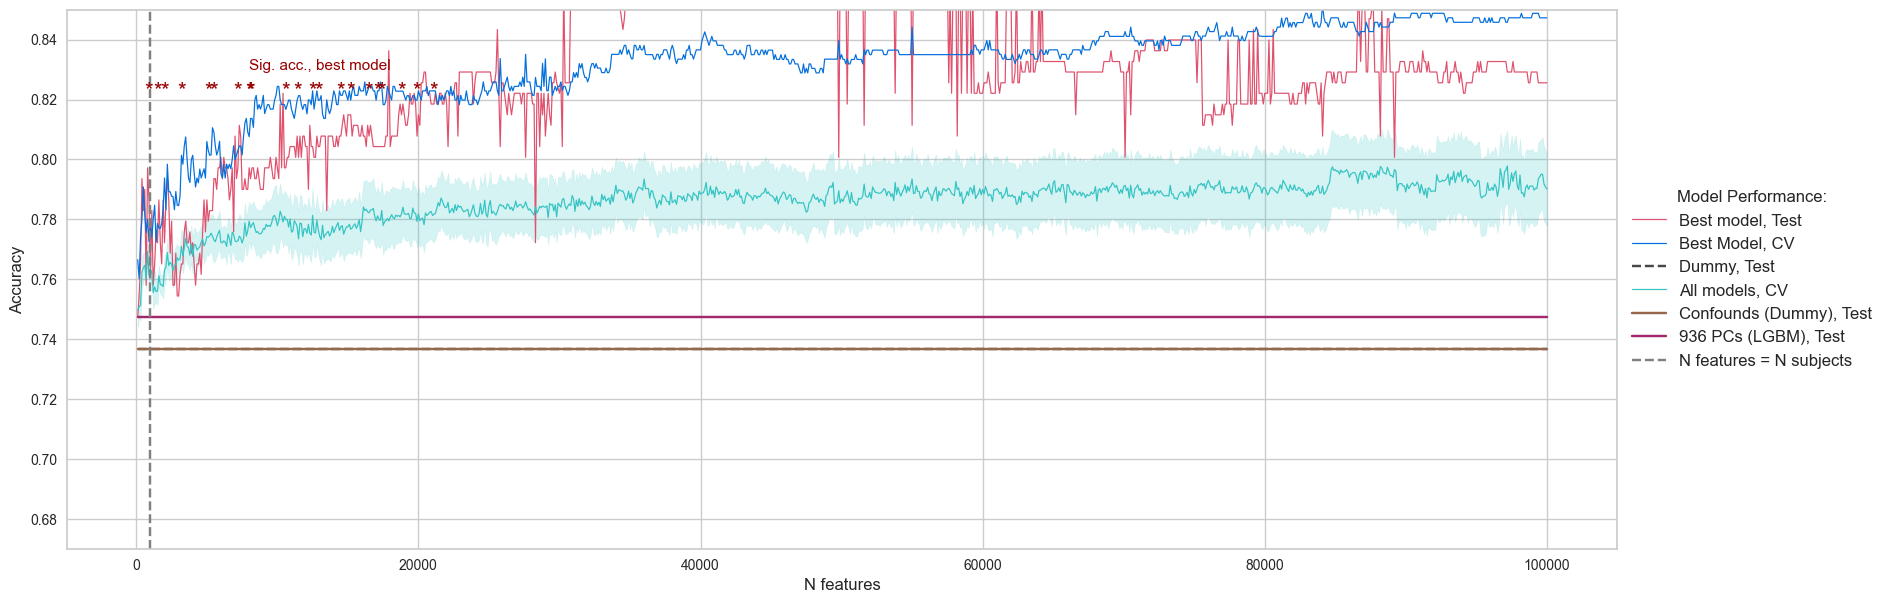

In [42]:
fig_dims = (20, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=best_models_test, estimator = None,
    x="N features", y="Accuracy", color="#e0516d", size = 0.7, legend = False, label = "Best model, Test"
)
sns.lineplot(
    data=best_cv_results, estimator = None,
    x="N features", y="Accuracy", color="#0470dc", size = 0.7, legend = False, label = "Best Model, CV"
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", linestyle = "--", label = "Dummy, Test"
)
sns.lineplot(
    data=dummy_filtered_results, errorbar = 'se',
    x="N features", y="Accuracy", color="#35c4c3", size = 0.7, legend = False, label = "All models, CV"
)
sns.lineplot(
    data=best_model_test_confound,x = "N features", y="Accuracy", color="#95684b", label = "Confounds (Dummy), Test"
)
sns.lineplot(
    data=best_model_test_pca,x = "N features", y="Accuracy", color="#a1286a", label = "936 PCs (LGBM), Test"
)

plt.axvline(x=936, color='gray', linestyle='--', label = "N features = N subjects")
ax.set(ylim=(0.67, 0.85))
for i in range(1, len(n_features), 10):
    if pval_auc[i] < 0.05:
        ax.annotate("*", xy=(n_features[i], 0.821), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
ax.annotate("Sig. acc., best model", xy=(13000, 0.83), fontsize=11, ha="center", color = "#980000")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12, title = "Model Performance:")
# ax.set_xlabel("Number of Features", fontsize=14)
# ax.set_ylabel("AUC", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

plt.savefig("../../figures/legend.svg", format = "svg", dpi = 300, bbox_inches='tight')

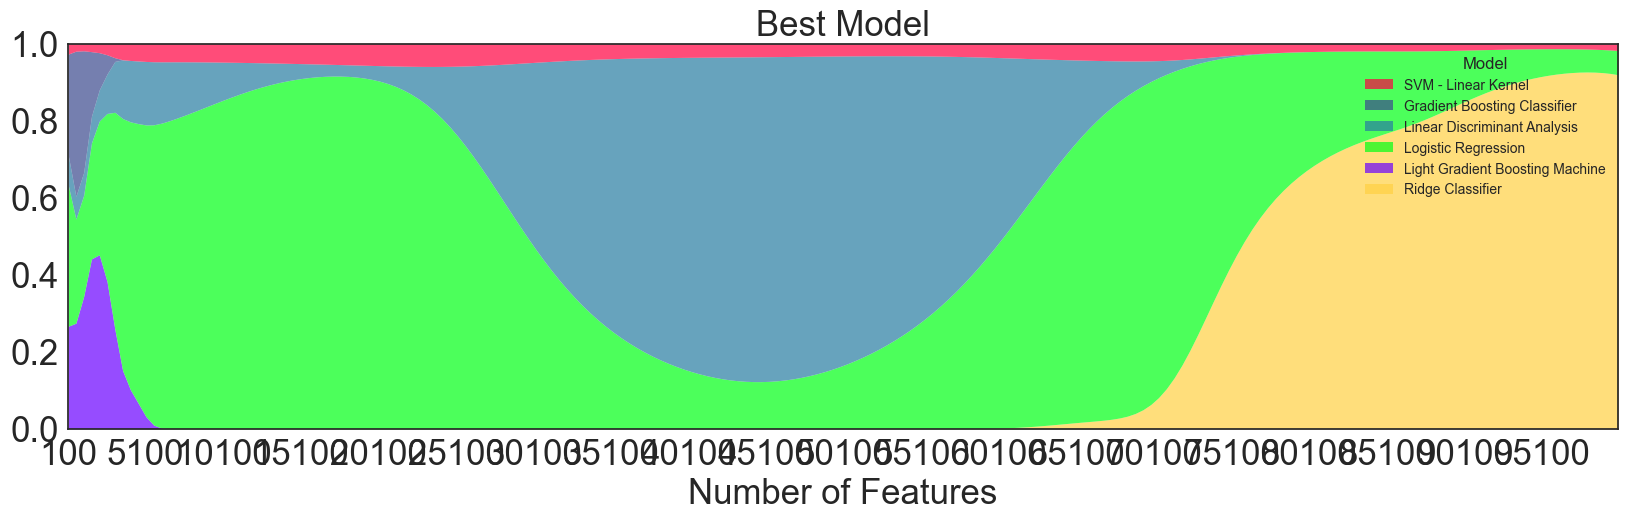

In [43]:
sns.set_style("white")
fig_dims = (20, 5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.kdeplot(data=best_models_test, x="N features", hue="Model", cumulative = False, multiple="fill", cut = 0, common_norm = True, bw_adjust = 1.2, bw_method = 'silverman', palette= ["#ff0040", "#3b498e", "#277da1", "#00ff15", "#6a00ff", "#ffd043", "#00d8e7"], alpha=0.7, fill=True, linewidth=0, legend = True)
ax.set_xlim([100, 100000])
ax.set_xticks(np.arange(100, 100001, 5000))
ax.set_xlabel("Number of Features", fontsize=25)
ax.set_ylabel("")

ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=25)
plt.title("Best Model", fontsize=25)
plt.savefig("../../figures/model_rank.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [150]:
best_models_test['Model'].unique()

array(['Gradient Boosting Classifier', 'K Neighbors Classifier',
       'Random Forest Classifier', 'Light Gradient Boosting Machine',
       'Linear Discriminant Analysis', 'Logistic Regression'],
      dtype=object)

## Feature Interpretation: Neurosynth & Cortical Surface

In [ ]:
feature_importance = np.load("z_feature_importance_matrix.npy")
feature_importance = np.max(feature_importance, axis = 1)
feature_importance = (feature_importance - np.min(feature_importance)) / (np.max(feature_importance) - np.min(feature_importance))


In [ ]:
feature_labels = np.load("feature_labels.npy").tolist()
best_100_features = pd.read_csv("best_features/100_best_features.csv")
best_100_indices = [feature_labels.index(col) for col in best_100_features.columns]

In [ ]:
feature_importance_df = pd.DataFrame({"Feature": best_100_features.columns.tolist(), "Importance": feature_importance[best_100_indices]})

In [ ]:
region_indices = []
for column in best_100_features.columns:
    value_index = int(column.split("_")[-1])
    i_region = int(str(value_index)[-3:])
    region_indices.append(i_region)

In [ ]:
feature_importance_df["region"] = region_indices

In [ ]:
transformed_df = feature_importance_df.groupby("region")["Importance"].sum().reset_index()
region_importance = np.zeros(1000)
region_importance[transformed_df["region"].values] = transformed_df["Importance"].values

In [ ]:
schaefer_labels_1000 = load_parcellation('schaefer', scale=1000, join=True)
region_importance = map_to_labels(region_importance, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

In [ ]:
lh, rh = surfaces['veryinflated']

In [ ]:
region_importance[np.where(region_importance == 0)] = np.nan
save_gifti(region_importance[:32492],"../../figures/cortex_regions/region_importance_lh")
save_gifti(region_importance[32492:],"../../figures/cortex_regions/region_importance_rh")


In [ ]:
from austin_utils import save_gifti
medial_lh = np.zeros(32492)
medial_rh = np.zeros(32492)
medial_lh[:] = np.nan
medial_rh[:] = np.nan

medial_lh[np.where(schaefer_labels_1000[0:32492] == 0)] = 1.0
medial_rh[np.where(schaefer_labels_1000[32492:] == 0)] = 1.0

save_gifti(medial_lh,"../../figures/cortex_regions/medial_left")
save_gifti(medial_rh,"../../figures/cortex_regions/medial_right")

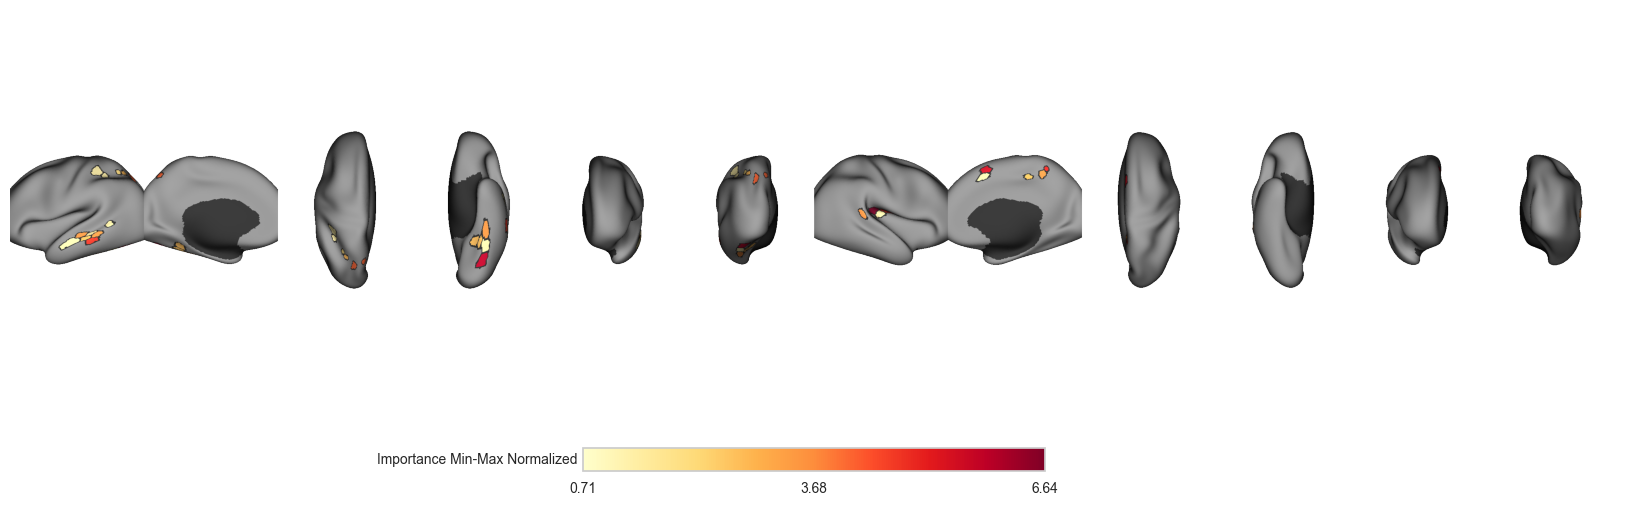

In [ ]:
all_views = ['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
imp_regions = Plot(lh, rh, brightness = 3, layout = "row", views=all_views,size=(2000, 500), zoom=1.5)
# kws = {'location': 'right', 'label_direction': 0, 'decimals': 1,
#        'fontsize': 12, 'n_ticks': 2, 'shrink': 5, 'aspect': 2,
#        'draw_border': False}

imp_regions.add_layer({'left': region_importance[:32492], 'right': region_importance[32492:]}, cmap = "YlOrRd", zero_transparent=True, cbar_label='Importance Min-Max Normalized', cbar=True)
imp_regions.add_layer({'left': region_importance[:32492], 'right': region_importance[32492:]}, cmap='gray',
            as_outline=True, cbar=False)
imp_regions.add_layer({'left': medial_lh, 'right': medial_rh}, cmap='gray',cbar = False)

fig = imp_regions.build()
fig.savefig(f"../../figures/cortex_regions/100_features_importance_regions.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [ ]:
best_models = pd.read_csv("results/best_models.csv")

In [ ]:
bin_edges = np.linspace(100, 100000, num=100)
bin_labels = np.arange(1, len(bin_edges))

best_models['N features bins'] = pd.cut(best_models['N features'], bins=bin_edges, labels=bin_labels, include_lowest=True)
# change the type of the column to numerical
best_models['N features bins'] = best_models['N features bins'].astype(int)

In [ ]:
best_models

Model  Accuracy     AUC  Recall   Prec.      F1  \
0    Random Forest Classifier    0.7450  0.7139  0.2183  0.5507  0.3104   
1      Extra Trees Classifier    0.7511  0.7364  0.1376  0.6050  0.2213   
2      Extra Trees Classifier    0.7603  0.7219  0.1716  0.6631  0.2621   
3      Extra Trees Classifier    0.7604  0.7314  0.1670  0.7174  0.2651   
4      Extra Trees Classifier    0.7589  0.7391  0.1614  0.7033  0.2594   
..                        ...       ...     ...     ...     ...     ...   
995          Ridge Classifier    0.8243  0.0000  0.5268  0.7465  0.6059   
996          Ridge Classifier    0.8243  0.0000  0.5268  0.7465  0.6059   
997          Ridge Classifier    0.8243  0.0000  0.5268  0.7465  0.6059   
998          Ridge Classifier    0.8243  0.0000  0.5268  0.7465  0.6059   
999          Ridge Classifier    0.8258  0.0000  0.5324  0.7490  0.6107   

      Kappa     MCC  TT (Sec)  N features  N features bins  
0    0.1896  0.2206     0.090         100                1  
1    0.1450  0.1983     0.091         200                1  
2    0.1853  0.2476     0.109         300                1  
3    0.1857  0.2573     0.125         400                1  
4    0.1798  0.2494     0.157         500                1  
..      ...     ...       ...         ...              ...  
995  0.4994  0.5172    13.441       99600               99  
996  0.4994  0.5172    12.144       99700               99  
997  0.4994  0.5172    11.906       99800               99  
998  0.4994  0.5172    13.176       99900               99  
999  0.5047  0.5222    11.854      100000               99  

[1000 rows x 11 columns]